In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display, HTML

base_folder = "../../../.."

## Topologies

In [2]:
def read_topology(topology_name):
    print(f"Topology name: {topology_name}")
    df = pd.read_csv(f"{base_folder}/resources/env/{topology_name}.txt", delimiter=";")
    display(HTML(df.to_html()))
        
read_topology("multi")
read_topology("single")

Topology name: multi


,ClusterID,ClusterName,Cores,Speed,Memory,numberOfHosts,memoryCapacityPerHost,coreCountPerHost
0,A01,A01,32,3.20,2048,1,256,32
1,B01,B01,48,2.93,1256,6,64,8
2,C01,C01,32,3.20,2048,2,128,16


Topology name: single


,ClusterID,ClusterName,Cores,Speed,Memory,numberOfHosts,memoryCapacityPerHost,coreCountPerHost
0,A01,A01,8,3.2,128,1,128,8


## Traces

In [3]:
df_trace = pd.read_parquet(f"{base_folder}/resources/bitbrains-small/trace/trace.parquet")
df_trace.head()

,id,timestamp,duration,cpu_count,cpu_usage
0,1019,2013-08-12 13:40:46+00:00,300000,1,0.000000
1,1019,2013-08-12 13:45:46+00:00,300000,1,11.703998
2,1019,2013-08-12 13:55:46+00:00,600000,1,0.000000
3,1019,2013-08-12 14:00:46+00:00,300000,1,11.703998
4,1019,2013-08-12 14:15:46+00:00,900000,1,0.000000


In [4]:
df_meta = pd.read_parquet(f"{base_folder}/resources/bitbrains-small/trace/meta.parquet")
df_meta.head()

,id,start_time,stop_time,cpu_count,cpu_capacity,mem_capacity
0,1019,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2926.000135,181352
1,1023,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2925.999560,260096
2,1026,2013-08-12 13:35:46+00:00,2013-09-11 13:39:58+00:00,1,2925.999717,249972
3,1052,2013-08-29 14:38:12+00:00,2013-09-05 07:09:07+00:00,1,2926.000107,131245
4,1073,2013-08-21 11:07:12+00:00,2013-09-11 13:39:58+00:00,1,2599.999649,179306


# Lets run this in OpenDC!

## Resulting Files

In [43]:
output_folder = f"{base_folder}/output"
workload = "workload=bitbrains-small"
seed = "seed=0"

df_host_single = pd.read_parquet(f"{output_folder}/host/topology=single/{workload}/{seed}/data.parquet")
df_host_multi = pd.read_parquet(f"{output_folder}/host/topology=multi/{workload}/{seed}/data.parquet")

df_server_single = pd.read_parquet(f"{output_folder}/server/topology=single/{workload}/{seed}/data.parquet")
df_server_multi = pd.read_parquet(f"{output_folder}/server/topology=multi/{workload}/{seed}/data.parquet")

df_service_single = pd.read_parquet(f"{output_folder}/service/topology=single/{workload}/{seed}/data.parquet")
df_service_multi = pd.read_parquet(f"{output_folder}/service/topology=multi/{workload}/{seed}/data.parquet")

def add_absolute_timestamp(df, start_dt):
    df["absolute_timestamp"] = start_dt + (df["timestamp"] - df["timestamp"].min())

add_absolute_timestamp(df_host_single, df_meta["start_time"].min())
add_absolute_timestamp(df_host_single, df_meta["start_time"].min())

add_absolute_timestamp(df_server_single, df_meta["start_time"].min())
add_absolute_timestamp(df_server_multi, df_meta["start_time"].min())

add_absolute_timestamp(df_service_single, df_meta["start_time"].min())
add_absolute_timestamp(df_service_multi, df_meta["start_time"].min())

### Host

In [44]:
display(list(df_host_multi.columns))
print(f"number of measurements: {len(df_host_multi)}")

['timestamp',
 'host_id',
 'cpu_count',
 'mem_capacity',
 'guests_terminated',
 'guests_running',
 'guests_error',
 'guests_invalid',
 'cpu_limit',
 'cpu_usage',
 'cpu_demand',
 'cpu_utilization',
 'cpu_time_active',
 'cpu_time_idle',
 'cpu_time_steal',
 'cpu_time_lost',
 'power_total',
 'uptime',
 'downtime',
 'boot_time']

number of measurements: 77859


### Server

In [45]:
display(list(df_server_multi.columns))
print(f"number of measurements: {len(df_server_multi)}")

['timestamp',
 'server_id',
 'host_id',
 'mem_capacity',
 'cpu_count',
 'cpu_limit',
 'cpu_time_active',
 'cpu_time_idle',
 'cpu_time_steal',
 'cpu_time_lost',
 'uptime',
 'downtime',
 'provision_time',
 'boot_time',
 'absolute_timestamp']

number of measurements: 408490


### Service

In [46]:
display(list(df_service_single.columns))
print(f"number of measurements: {len(df_host_single)}")

['timestamp',
 'hosts_up',
 'hosts_down',
 'servers_pending',
 'servers_active',
 'attempts_success',
 'attempts_failure',
 'attempts_error',
 'absolute_timestamp']

number of measurements: 8651


## Power Usage

In [47]:
print(f"single topology: {df_host_single.power_total.sum()}")
print(f"multi topology:   {df_host_multi.power_total.sum()}")

single topology: 822692246.2425151
multi topology:   5870271518.168591


## CPU usage

In [48]:
print(f"single topology: {df_host_single.cpu_utilization.mean()}")
print(f"multi topology:   {df_host_multi.cpu_utilization.mean()}")

single topology: 0.7799672554077309
multi topology:   0.3421434368579651


## CPU utilization

In [49]:
print(f"multi topology:   {df_host_multi.cpu_utilization.mean()}")
print(f"single topology: {df_host_single.cpu_utilization.mean()}")

multi topology:   0.3421434368579651
single topology: 0.7799672554077309


## Plotting Results

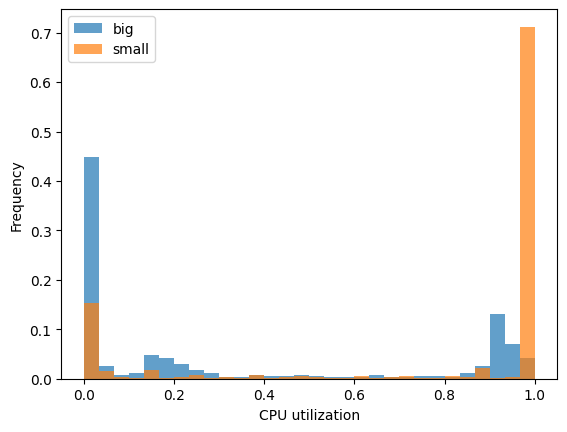

In [33]:
data = df_host_multi.cpu_utilization
plt.hist(data, weights=np.ones_like(data) / len(data),
         alpha=0.7, label="big", bins=30)


data = df_host_single.cpu_utilization
plt.hist(data, weights=np.ones_like(data) / len(data),
         alpha=0.7, label="small", bins=30)

plt.xlabel("CPU utilization")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [34]:
df_host_single.cpu_utilization.value_counts()

1.000000    6146
0.000009       9
0.002294       2
0.027410       2
0.021973       2
            ... 
0.028164       1
0.029120       1
0.028367       1
0.030243       1
0.030289       1
Name: cpu_utilization, Length: 2488, dtype: int64

In [35]:
df_host_multi.host_id.unique()

array([b'\xf8\x8b\xb8\xa8rL\x81\xec\x00\x00\x00\x00\x00\x00\x00\x02',
       b'\x1b9\x89jQ\xa8t\x9b\x00\x00\x00\x00\x00\x00\x00\x03',
       b'\xc5\x84\x13:\xc9\x16\xab<\x00\x00\x00\x00\x00\x00\x00\x00',
       b'S\xcb\x9f\x0ct~\xa2\xea\x00\x00\x00\x00\x00\x00\x00\x04',
       b'\xe2 \xa89{\x1d\xcd\xaf\x00\x00\x00\x00\x00\x00\x00\x00',
       b'\x06\xc4]\x18\x80\tEO\x00\x00\x00\x00\x00\x00\x00\x01',
       b',\x82\x9a\xbe\x1fE2\xe1\x00\x00\x00\x00\x00\x00\x00\x05',
       b'>\xe5x\x90A\xc9\x8a\xc3\x00\x00\x00\x00\x00\x00\x00\x01',
       b'nx\x9ej\xa1\xb9e\xf4\x00\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)

In [54]:
df_server_single.cpu_count.value_counts()

1     141065
4     118263
8      77859
2      62652
32      8651
Name: cpu_count, dtype: int64

In [56]:
df_host_single.cpu_count.value_counts()

8    8651
Name: cpu_count, dtype: int64